In [ ]:
#preprocessing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#modelling

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Training Data

train = pd.read_csv('/content/train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In this case we want to predict whether a passenger on Titanic survived or not.



In [ ]:
# Testing data features
test = pd.read_csv('/content/test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Exploratory Data Analysis(EDA)

In [ ]:
#distribution of target values
train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

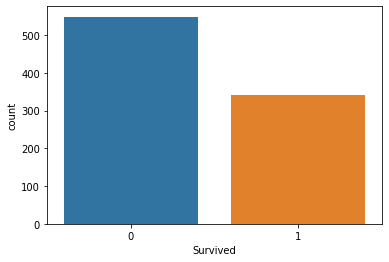

In [ ]:
sns.countplot(x = 'Survived',data = train)

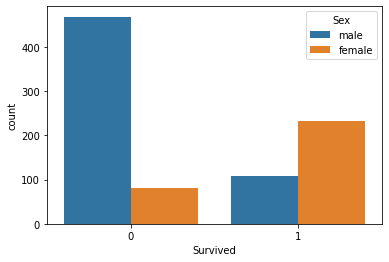

In [ ]:
sns.countplot(x = 'Survived',hue = 'Sex',data = train)

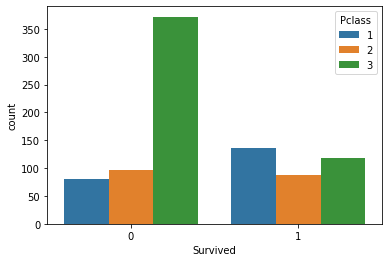

In [ ]:
sns.countplot(x = 'Survived',hue = 'Pclass',data = train)

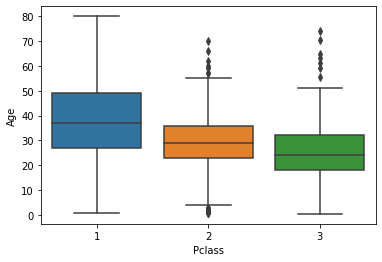

In [ ]:
sns.boxplot(x='Pclass',y='Age',data=train)

Thus, around 549 people perished while 342 survived
We can see that females survived in much higher proportions than males did


Examining Missing Values


In [ ]:
print(train.isnull().sum())
print("---------------------")
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
---------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Let’s create a function to impute ages regarding the corresponding age average per class.

In [ ]:
def add_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        return int(train[train["Pclass"] == Pclass]["Age"].mean())
    else:
        return Age

apply add_age function

In [ ]:
train['Age'] = train[['Age','Pclass']].apply(add_age,axis=1)
test['Age'] = test[['Age','Pclass']].apply(add_age,axis=1)

In [ ]:
#Cabin has max missing values so it will be good that we drop this column
train.drop("Cabin",inplace=True,axis=1)
test.drop("Cabin",inplace=True,axis=1)

In [ ]:
#Embarkrd has just two missing values so we can replace those values by mode
train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0],inplace=True)

In [ ]:
#fare has 1 missing values so just replace it by mean
test['Fare'].fillna(test['Fare'].mean(),inplace=True)


Creating new Features


In [ ]:
#create new family features by using two columns
def combine(df,col1,col2):
    df["Family"] = df[col1]+df[col2]
    df.drop([col1,col2],inplace=True,axis=1)
    return df

train = combine(train,'SibSp','Parch')
test = combine(test,'SibSp','Parch')

In [ ]:
train['Age'].describe()

count    891.000000
mean      23.699966
std       17.731181
min       -0.500000
25%        6.000000
50%       24.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

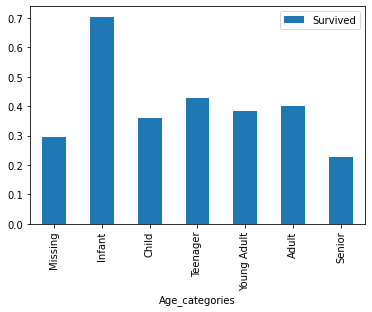

In [ ]:
#convert age column to categorical values
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()

Encoding Categorical Variables

In [ ]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

for column in ["Pclass","Sex","Age_categories",'Embarked']:
    train = create_dummies(train,column)
    test = create_dummies(test,column)

Dropping Unnecessary columns

In [ ]:
train.drop(['Name','Sex','Ticket','Pclass','Age_categories','Embarked'],inplace=True,axis=1)
test.drop(['Name','Sex','Ticket','Pclass','Age_categories','Embarked'],inplace=True,axis=1)

In [ ]:
lr = LogisticRegression()
columns = ['PassengerId', 'Age', 'Fare','Family',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

lr.fit(train[columns], train["Survived"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
X = train[columns]
y = train['Survived']

train_X, val_X, train_y, val_y = train_test_split(
    X, y, test_size=0.20,random_state=0)

In [ ]:
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(val_X)
accuracy = accuracy_score(val_y, predictions)
print(accuracy)
from sklearn.metrics import classification_report
print(classification_report(val_y,predictions))

0.8100558659217877
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [ ]:
lr = LogisticRegression()
lr.fit(X,y)
predictions_test = lr.predict(test[columns])

In [ ]:
submission_df = pd.DataFrame({'PassengerId' : test['PassengerId'],
                              'Survived':predictions_test})
submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
